In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from dataloader import MRIDataset
from residual3dunet.model import ResidualUNet3D
import matplotlib.pyplot as plt
from utils import get_loaders
import torchvision.transforms.functional as F
import torchvision.transforms as T
import random
import h5py
import numpy as np
from ipywidgets import interact
# from elastic_transform import RandomElastic
import nibabel as nib
#from residual3dunet.modelorig import ResidualUNet3D

import cv2
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt
import numbers
from PIL import Image

In [ ]:
dataset = MRIDataset(train=True)
train, val = torch.utils.data.random_split(dataset, [40, 10])

dataloader = DataLoader(dataset = train, batch_size= 41, shuffle= True, num_workers=2)

In [ ]:
# dataset = MRIDataset(train=True, transform=True)

train_kwargs = {'batch_size': 10}
cuda_kwargs = {'num_workers': 1, 'pin_memory': True,'shuffle': True}
train_kwargs.update(cuda_kwargs)

#train, val = random_split(dataset, [40, 10])
# dataloader = DataLoader(dataset = val, **train_kwargs)

In [ ]:
dataloader, valloader = get_loaders(train=True, transform=True, **train_kwargs)

In [ ]:
dataiter = iter(dataloader)
data = dataiter.next()
features, labels = data
print(features.shape)
print(labels.shape)

In [ ]:
model = ResidualUNet3D(in_channels=1, out_channels=1)

In [ ]:
dataset2 = MRIDataset(train=True, transform=T.Compose([T.ToTensor(), T.RandomHorizontalFlip(), T.RandomCrop((240,240), padding=50, pad_if_needed=True)]))


In [ ]:

test_loader = DataLoader(dataset = dataset2, batch_size=50, shuffle=False)

# dataiter = iter(test_loader)

# first = next(dataiter)
# second = next(dataiter)

# features1, labels1 = first
# features2, labels2 = second

for data, target in test_loader:
    print(data.shape)
    print(target.shape)



In [102]:
class RandomElastic(object):
    """Random Elastic transformation by CV2 method on image by alpha, sigma parameter.
        # you can refer to:  https://blog.csdn.net/qq_27261889/article/details/80720359
        # https://blog.csdn.net/maliang_1993/article/details/82020596
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.map_coordinates.html#scipy.ndimage.map_coordinates
    Args:
        alpha (float): alpha value for Elastic transformation, factor
        if alpha is 0, output is original whatever the sigma;
        if alpha is 1, output only depends on sigma parameter;
        if alpha < 1 or > 1, it zoom in or out the sigma's Relevant dx, dy.
        sigma (float): sigma value for Elastic transformation, should be \ in (0.05,0.1)

        img (numpy array) 3D:(C * D * W * H) 2D:(C * W * H)
        mask (numpy array) same size/shape as img, if not assign, set None.
       
    Output:
        transformed img (numpy array) 3D:(C * D * W * H) 2D:(C * W * H)
        transformed mask (numpy array) 3D: 
    """
    def __init__(self, alpha, sigma):
        assert isinstance(alpha, numbers.Number) and isinstance(sigma, numbers.Number), \
            "alpha and sigma should be a single number."
        assert 0.05 <= sigma <= 0.1, \
            "In pathological image, sigma should be in (0.05,0.1)"
        self.alpha = alpha
        self.sigma = sigma

    @staticmethod
    def RandomElasticCV2(img, alpha, sigma, mask=None):
        alpha = img.shape[1] * alpha
        sigma = img.shape[1] * sigma
        if mask is not None:
            mask = np.array(mask).astype(np.uint8)
            img = np.concatenate((img, mask), axis=3)

        # W * H * D * C
        shape = img.shape
        depth = shape[2]

        # W * H * C
        shape = (shape[0], shape[1], shape[3])

        transformed = []

        dx = gaussian_filter((np.random.rand(*shape) * 2 - 1), sigma) * alpha
        dy = gaussian_filter((np.random.rand(*shape) * 2 - 1), sigma) * alpha

        x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
        indices = np.reshape(y + dy, (-1, 1)), np.reshape(x + dx, (-1, 1)), np.reshape(z, (-1, 1))

        # Across the depth axis
        for i in range(depth):
            transformed_img = map_coordinates(img[:,:,i,:], indices, order=0, mode='reflect').reshape(shape)
            transformed.append(transformed_img)

        img = np.array(transformed)

        # Move channel to dimension1
        img = np.moveaxis(img,3,0)

        if mask is not None:
            return img[:1, ...], img[1:,...]
        else:
            return img

    def __call__(self, img, mask=None):

        # 4D input (C * D * W * H)
        if len(img.shape) == 4:
            img = np.moveaxis(img,1,3)
            img = np.moveaxis(img,0,3)

        if len(mask.shape) == 4:
            mask = np.moveaxis(mask,1,3)
            mask = np.moveaxis(mask,0,3)

        return self.RandomElasticCV2(np.array(img), self.alpha, self.sigma, mask)

    def __repr__(self):
        format_string = self.__class__.__name__ + '(alpha value={0})'.format(self.alpha)
        format_string += ', sigma={0}'.format(self.sigma)
        format_string += ')'
        return format_string


In [103]:
h5ftrain = h5py.File('dataset/T2train.h5','r')
h5ftrainmask = h5py.File('dataset/T2trainmask.h5','r')

data = h5ftrain[f'T2data_1'][:]
target = h5ftrainmask[f'T2maskdata_1'][:]

print(data.shape)
print(target.shape)

preprocess = RandomElastic(alpha=2, sigma=0.06)
data1, target1 = preprocess(data, target)

print(data1.shape)
print(target1.shape)


(1, 14, 240, 240)
(1, 14, 240, 240)
(2, 14, 240, 240)
(1, 14, 240, 240)
(1, 14, 240, 240)


(-0.5, 239.5, 239.5, -0.5)

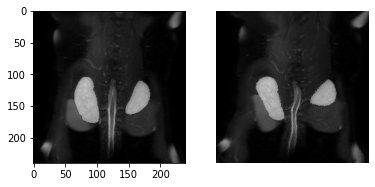

In [104]:
f, axarr = plt.subplots(1,2)

axarr[0].imshow(data[0,8,:,:],cmap='gray')
axarr[0].imshow(target[0,8,:,:],cmap='gray',alpha=0.3)
axarr[1].imshow(data1[0,8,:,:],cmap='gray')
axarr[1].imshow(target1[0,8,:,:],cmap='gray',alpha=0.3)
plt.axis('off')



In [105]:
# index = random.randint(0,49)
def explore_3d_image(layer):

    plt.figure(figsize=(5,10))
    plt.imshow(data1[0,layer,:,:],cmap='gray')
    plt.imshow(target1[0,layer,:,:],cmap='gray', alpha=0.3)
    plt.title('Explore Layers of Kidney MRI')
    plt.axis('off')
    return layer

interact(explore_3d_image, layer=(0,13))

interactive(children=(IntSlider(value=6, description='layer', max=13), Output()), _dom_classes=('widget-intera…

<function __main__.explore_3d_image(layer)>